In [1]:
# module
import pexpect
import sys
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import time
from numba import jit, f8, i8, b1, void
from sklearn.linear_model import LinearRegression

In [2]:
max_batch = 10000       #学習回数
n_step = 200             # n_step TD error, dimensionless time = 1
dim_obs = 8            # dimension of observe
dim_act  = 1           # dimension of action
dim_the   = dim_obs    # dimension of theta
gam = 0.9              # 割引率
dt = 0.005             #時間刻み

#== 本手法の致命的なパラメータ ==#
batch_size = 4000            # バッチ内でどれだけDNSするか、今の設定では無次元時間50
alpha_t = 1e-5               # 方策パラメータθの学習率
num_train_episode = 10       # Qのフィッティングにつかうミニバッチ数

In [3]:
gamma_list = [1.]
num_components=100
scaler_observe = sklearn.preprocessing.StandardScaler()
feature = sklearn.pipeline.FeatureUnion([
    (str(i), RBFSampler(gamma=gamma_list[i],
                       n_components=num_components))
    for i in range(len(gamma_list))
])

In [4]:
prc = pexpect.spawn("/bin/bash")
prc.sendline("rm action.bin")
prc.sendline("rm observe.bin")
prc.sendline("rm *pickle")
prc.sendline("rm *_movie.bin")

15

In [5]:
def minimize_TDerror5(obs_np,the_np,act_np,rew_np,phi_imp_np,n_step,gam,rcond=1e-15):
#====経験を時間ステップtとt+1に分ける===#
    obs0,the0,act0,phi0 = obs_np[:-n_step],the_np[:-n_step],act_np[:-n_step],phi_imp_np[:-n_step]
    obs1,the1,act1,phi1 = obs_np[n_step:], the_np[n_step:], act_np[n_step:], phi_imp_np[n_step:]


#=== 連立方程式の行列成分の準備 ===#
    p=gam*phi1-phi0
    
    rew0=np.zeros(len(rew_np)-n_step)
    gams=gam**(np.arange(n_step)/n_step)
    for n in range(len(rew0)):
        rew0[n]=np.sum(rew_np[n:n+n_step]*gams) 
    
#=== 連立方程式の行列の設定 ===# 
    A = np.matmul(p.T,p)
    Y =-np.matmul(rew0,p)

#=== 連立方程式を解く ===#
    #X=np.linalg.solve(A,Y)
    A2=np.linalg.pinv(A,rcond=rcond, hermitian=True)
    X=np.matmul(A2,Y)

#=== 解の整理 ===#
    TDerr=(((np.matmul(p,X)+rew0)**2).mean()/(np.matmul(phi0,X)**2).mean())**0.5
    print(TDerr)
    
#=== 価値関数の算出 ===#    
    Value=np.matmul(phi0,X)
    #plt.plot(Value)
    #plt.show()

#=== 勾配算出 ===#
    #lr = LinearRegression(fit_intercept=True)
    #lr.fit(the0, Value)                         # 線形モデルの重みを学習
    #dthe = lr.coef_*(1-gam**(1./n_step))   
    
    #== thetaの拡張 ==#
    one=np.ones(the0.shape[0]).reshape(-1,1)
    the0_expand=np.concatenate([the0, one], 1)

    #== 連立方程式の行列の設定 ==#
    A = np.matmul(the0_expand.T,the0_expand)
    Y =np.matmul(Value,the0_expand)

    #=== 連立方程式を解く ===#
    A2=np.linalg.pinv(A,rcond=rcond, hermitian=True)
    X=np.matmul(A2,Y)
    dthe=X[:the0.shape[1]]*(1-gam**(1./n_step)) 
    
    #plt.scatter(the0[:,0]*100,the0[:,1]*100,c=Value,s=2)
    #plt.show()
    #print(the0.shape)

    #plt.plot(the0[:,0]*100)
    #plt.show()
    #print(the0.shape)
    
    #plt.plot(rew0)
    #plt.show()
    #print(the0.shape)
    
    return dthe,TDerr #w_weight,v_weight#,A,Y,X,A2

check (4000,)


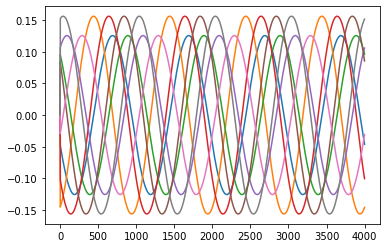

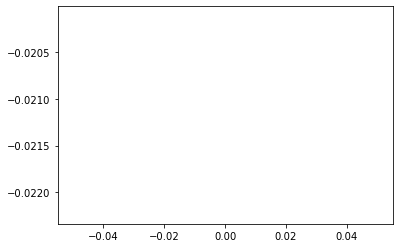

#==================== 1  episode ====================#
J       =  -0.021172654794727325
dtheta  =  [0. 0. 0. 0. 0. 0. 0. 0.]
theta   =  [0. 0. 0. 0. 0. 0. 0. 0.]
TDerr   =  0
#==================== TIME ====================#
DNS              :  40.11184501647949
Object function  :  0.0008218288421630859
Train data       :  0.0006418228149414062
Create numpy     :  0
Feature          :  0
Q fit3           :  0
Policy gradient  :  0
Adjust dtheta    :  0
Upadate theta    :  0
Plot             :  0.3515195846557617
Pickle           :  0.038419485092163086
#=============================================#
TOTAL TIME per minibatch :  40.50442957878113


KeyboardInterrupt: 

In [6]:
#=== 方策パラメータの初期化 ===#
np.random.seed(seed=0)
the=np.zeros(dim_the)#np.random.normal(loc=0,scale=1e-5,size=dim_the)
dthe=np.zeros(dim_the)

#===経験変数===#
obs     = np.zeros(dim_obs)     # observe_t
obs_new = np.zeros(dim_obs)     # observe_{t+1}
act     = np.zeros(dim_act)     # action_t

# == history == #
J_total_history = []         # ミニバッチ内平均の報酬
the_train_history = []       
obs_train_history = []
act_train_history = []
rew_train_history = []
rew0_train_history = []

total_step = 0               # total step of DNS 


TDerr,TDerr2,TDerr3 = 0,0,0
DNS_time ,Of_time,data_time,np_time,feature_time=0,0,0,0,0
Qfit1_time,Qfit2_time,Qfit3_time,gradient_time,adjust_time,update_time,plot_time,pickle_time=0,0,0,0,0,0,0,0


#========== Run the Fortran code for DNS ==========#
prc = pexpect.spawn("/bin/bash")
prc.sendline("export OMP_NUM_THREADS=8")
prc.sendline("./test.x")
#prc.logfile = sys.stdout
time.sleep(5)

#=== learning starts ===#
for i_episode in range(1, max_batch + 1):  
    total1 = time.time()##########################################################
    t1=time.time()##########################################################
    outfile = open("action.bin", 'wb')
    
    prc.sendline(str(i_episode))
    prc.expect("INPUT0", timeout=1000000)
    infile = open("observe.bin", 'rb')
    
    #=== Initialize for DNS ===#
    steps = 0 
    
    #========== Perform DNS ==========#
    while True:

        
        if i_episode <= num_train_episode+1 and steps==0 and i_episode>1:
            dthe=np.random.normal(loc=0,scale=1e-2,size=dim_the)        
        the += dthe*alpha_t
        #the[0],the[1]=-10,10
        
        #=== 方策により行動を決定 ===#
        act[0] = np.dot(obs,the)
        
        #=== Give action to Fortran ===#
        prc.expect("INPUT", timeout=1000000)
        outfile.write(struct.pack('<d', act[0]))
        outfile.flush()
            
        #=== Receive state from Fortran ===#    
        prc.expect("OUTPUT", timeout=1000000) 
        rew0 = struct.unpack('<d', infile.read(8))[0]
                
        for i in range(dim_obs):
            obs_new[i]=struct.unpack('<d', infile.read(8))[0]
        
        #=== 報酬関数 ===#
        angle = obs_new[0] + obs_new[1]*dt
        rew=-rew0-10*np.abs(np.arctan2(np.sin(angle),np.cos(angle)) - angle)
        #rew=-rew0-5*(np.tanh((np.abs(angle)-np.pi*3/4)/0.01)+1)

        #=== for history ===#
        the_train_history.append(np.array(the)) # Save total history of theta (not good)
        obs_train_history.append(np.array(obs)) # Save total history of observe_t
        act_train_history.append(np.array(act)) # Save total history of action_t
        rew_train_history.append(np.array(rew)) # save history of reward_{t+1}
        rew0_train_history.append(np.array(rew0)) # save history of reward_{t+1}
        
        #=== 時間発展 ===#
        obs = obs_new  
        steps += 1; total_step += 1
        
        #=== Termination conditions for DNS ===#
        if steps >= batch_size:
            break
                
    prc.expect("END", timeout=1000000)
    outfile.close(); infile.close()
    t2=time.time()##########################################################
    DNS_time=t2-t1##########################################################
    
#=== Object function ===#
    t1=time.time()##########################################################
    J=np.mean(np.array(rew0_train_history)[-batch_size:])
    J_total_history.append(J)
    t2=time.time()##########################################################
    Of_time=t2-t1##########################################################
    
#==== training data ====#    
    t1=time.time()##########################################################
    if len(obs_train_history)==batch_size*(num_train_episode+1):
        del obs_train_history[:batch_size]
        del rew_train_history[:batch_size]
        del rew0_train_history[:batch_size]
        del the_train_history[:batch_size]
        del act_train_history[:batch_size]
    print("check", np.array(rew_train_history).shape)
    t2=time.time()##########################################################
    data_time=t2-t1##########################################################
    
#========= 強化学習開始 =========#    
    if i_episode >= num_train_episode+1:
        t1=time.time()##########################################################
        obs_np=np.array(obs_train_history)
        rew_np=np.array(rew_train_history)
        the_np=np.array(the_train_history)
        act_np=np.array(act_train_history)
        t2=time.time()##########################################################
        np_time=t2-t1##########################################################

        
#========= 特徴量の取得 =========# 
        t1=time.time()##########################################################
        #print('episode for phi',obs_np[-batch_size:].shape)
        
        obs_the_np=np.concatenate([obs_np, the_np], 1)
        #obs_the_scale_np = (obs_the_np - obs_the_np.mean(0)) / obs_the_np.std(0)
        phi_imp_np = feature.fit_transform(obs_the_np)
        t2=time.time()##########################################################
        feature_time=t2-t1##########################################################
        
#==== 行動価値関数のフィッティング ====#         
        t1=time.time()##########################################################
        dthe,TDerr=minimize_TDerror5(obs_np,the_np,act_np,rew_np,phi_imp_np,n_step,gam)
        t2=time.time()##########################################################
        Qfit3_time=t2-t1##########################################################
        #alpha_t=0.001/TDerr*10.**(-6)
        #print("differ",((w_weight-w_weight2)**2).max(),((v_weight-v_weight2)**2).max())  
        #alpha_t=alpha_t0-alpha_t0/epi_fin * (i_episode-num_train_episode) #1e-4/TDerr*alpha_t_base
        #alpha_t=alpha_t0 * ( 1/(i_episode-num_train_episode)**nn - 1/(epi_fin+1)**nn ) * (epi_fin+1)**nn / ((epi_fin+1)**nn -1)
        #if alpha_t < 0:
        #    alpha_t=0
        if(i_episode==60 or i_episode==110):# or i_episode==160):
            alpha_t=alpha_t/10
        #if(i_episode==num_train_episode+1):
        #    dthe=dthe*1e-12

        
#=== 観測と目的関数のグラフ表示 ===#
    t1=time.time()##########################################################
    plt.plot(obs_train_history[-batch_size:]); plt.show()
    plt.plot(J_total_history); plt.show()
    t2=time.time()##########################################################
    plot_time=t2-t1##########################################################

#=== 経験と目的関数の保存 ===#
    t1=time.time()##########################################################
    with open('obs.pickle', 'wb') as f:
        pickle.dump(obs_train_history,f)
    with open('act.pickle', 'wb') as f:
        pickle.dump(act_train_history,f)
    with open('J.pickle', 'wb') as f:
        pickle.dump(J_total_history,f)
    #with open('the.pickle', 'wb') as f:
    #    pickle.dump(the_train_history,f)
    #with open('rew.pickle', 'wb') as f:
    #    pickle.dump(rew_train_history,f)
    t2=time.time()##########################################################
    pickle_time=t2-t1##########################################################
    
#=== モニタリング ===#
    print("#====================",i_episode, " episode ====================#")
    print("J       = ", J           )
    print("dtheta  = ", dthe        )
    print("theta   = ", the         )
    print("TDerr   = ", TDerr       )
    #print("w       = ", w_weight)
    #print("v       = ", v_weight)
    
#=== 時間関連 ===#   
    print("#==================== TIME ====================#")
    print("DNS              : ", DNS_time       )
    print("Object function  : ", Of_time        )
    print("Train data       : ", data_time      )
    print("Create numpy     : ", np_time        )
    print("Feature          : ", feature_time   )
    #print("Q fit1           : ", Qfit1_time     )
    #print("Q fit2           : ", Qfit2_time     )
    print("Q fit3           : ", Qfit3_time     )
    print("Policy gradient  : ", gradient_time  )
    print("Adjust dtheta    : ", adjust_time    )
    print("Upadate theta    : ", update_time    )
    print("Plot             : ", plot_time      )
    print("Pickle           : ", pickle_time    )
    total2 = time.time()##########################################################
    print("#=============================================#")
    print("TOTAL TIME per minibatch : ", total2-total1  )

In [ ]:
with open('J.pickle','rb') as f:
    J=np.array(pickle.load(f))

In [ ]:
plt.plot(J)

In [ ]:
with open('J.pickle','rb') as f:
    J=np.array(pickle.load(f))
with open('obs.pickle','rb') as f:
    obs=np.array(pickle.load(f))
with open('act.pickle','rb') as f:
    act=np.array(pickle.load(f))  
for i in range(len(J)):
    print(J[i])